In [2]:
!nvidia-smi

Failed to initialize NVML: Unknown Error


In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Infer

In [33]:
workspace_dir = '/nfs/Workspace/TeethSeg'

import os
import sys
from pathlib import PurePath
sys.path.append(workspace_dir)

import pandas as pd

from monai.transforms import (
   Compose,
   AddChanneld,
   EnsureChannelFirstd,
   LoadImaged,
   Orientationd,
   SqueezeDimd,
   LoadImage
)

from data_utils.data_loader_utils import load_data_dict_json
from data_utils.teeth_dataset import get_data_dicts
from data_utils.utils import get_pid_by_file
from data_utils.visualization import show_img_lbl, show_img_lbl_pred, show_img_lbl_preds, show_img_lbl_preds_overlap

from expers.infer_utils import get_tune_model_dir, get_data_path, get_pred_path

### get mask

In [35]:
# mask
model_name = 'cswinunetr_96_3_mask'
data_name = 'tooth'
exp_name = 'exp_1_drop0_0_01_mask' 

root_exp_dir = os.path.join(
    workspace_dir, 
    'exps',
    model_name,
    data_name,
    exp_name
)


data_dir = '/nfs/Workspace/dataset/teeth/data50'
data_json = os.path.join(data_dir, 'data.json')
model_dir = os.path.join(root_exp_dir, 'models')
log_dir = os.path.join(root_exp_dir, 'logs')
eval_dir = os.path.join(root_exp_dir, 'evals')
infer_dir = os.path.join(root_exp_dir, 'infers')

best_checkpoint = os.path.join(model_dir, 'best_model.pth')
final_checkpoint = os.path.join(model_dir, 'final_model.pth')

print('best model:', best_checkpoint)
print(f'infer dir: {infer_dir}\n')

# use testing data
tr_ds, val_ds, tt_ds = load_data_dict_json(data_dir, data_json)
data_dict = tt_ds[3]
data_dict['pred'] = get_pred_path(root_exp_dir, exp_name,data_dict['image'])
img_pth = data_dict['image']
lbl_pth = data_dict['label']
pred_mask_pth = data_dict['pred']

# use other data
# other_data_name = '1000966359_20180113.nii.gz'
# img_pth = os.path.join(data_dir, 'image', other_data_name)
# lbl_pth = os.path.join(data_dir, 'label', other_data_name)
# pred_mask_pth = os.path.join(infer_dir, other_data_name)

print('\nimg pth:', img_pth)
print('lbl pth:', lbl_pth)
print('pred mask pth:', pred_mask_pth)

%cd /nfs/Workspace/TeethSeg/exps/{model_name}/{data_name}

best model: /nfs/Workspace/TeethSeg/exps/cswinunetr_96_3_mask/tooth/exp_1_drop0_0_01_mask/models/best_model.pth
infer dir: /nfs/Workspace/TeethSeg/exps/cswinunetr_96_3_mask/tooth/exp_1_drop0_0_01_mask/infers

load json from /nfs/Workspace/dataset/teeth/data50/data.json
train files (30): ['1000966359_20180113', '1000889125_20191101', '1001162439_20180110', '1000983254_20180904', '1001152328_20180112', '1001218388_20180109', '1000915187_20180115', '1001223657_20180112', '1001142392_20180511', '1001142392_20180110', '1001142392_20180116', '1000971031_20180112', '1001022839_20180110', '1001173165_20171205', '1000995722_20180112', '1000889125_20200421', '1001127112_20180109', '1001247962_20180115', '1001133637_20180110', '1001172283_20190622', '1001152328_20180910', '1001232054_20180109', '1001020384_20180114', '1000813648_20180116', '1001218388_20161024', '1001068663_20180116', '1001009635_20180116', '1001218388_20171102', '1000889125_20171016', '1000889125_20180521']
val files (10): ['100

In [36]:
!PYTHONPATH={workspace_dir} /opt/conda/envs/TeethSeg/bin/python /nfs/Workspace/TeethSeg/expers/infer.py \
--model_name={model_name} \
--data_name={data_name} \
--data_dir={data_dir} \
--model_dir={model_dir} \
--infer_dir={infer_dir} \
--checkpoint={best_checkpoint} \
--img_pth={img_pth} \
--lbl_pth={lbl_pth} \
--out_channels=2 \
--scale_intensity_type='range' \
--a_min=218 \
--a_max=3187 \
--space_x=0.4 \
--space_y=0.4 \
--space_z=0.4 \
--roi_x=96 \
--roi_y=96 \
--roi_z=96 \
--infer_overlap=0.25

cuda is available
model: cswinunetr_96_3_mask
img_size:  (96, 96, 96)
patch_size:  (2, 2, 2)
window_size:  (7, 7, 7)
=> loaded checkpoint '/nfs/Workspace/TeethSeg/exps/cswinunetr_96_3_mask/tooth/exp_1_drop0_0_01_mask/models/best_model.pth' (epoch 2321) (bestacc 0.9788311123847961) (early stop count 0)
infer data: {'image': '/nfs/Workspace/dataset/teeth/data50/image/1001213121_20180115.nii.gz', 'label': '/nfs/Workspace/dataset/teeth/data50/label/1001213121_20180115.nii.gz'}
<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.

infer test time aug:
dice: 0.972848
hd95: 1.0
avg dice: 0.972848
avg hd95: 1.0

infer test original:
dice: 0.972848
hd95: 1.0
avg dice: 0.972848
avg hd95: 1.0
2023-07-17 12:59:26,495 INFO image_writer.py:194 - writing: /nfs/Workspace/TeethSeg/exps/cswinunetr_96_3_mask/tooth/exp_1_drop0_0_01_mask/infers/1001213121_20180115.nii.g

### get center

In [24]:
# mask
model_name = 'cswinunetr_96_3_center_edge'
data_name = 'tooth'
exp_name = 'exp_2_drop0_0_01_center'

# edge
# model_name = 'cswinunetr_96_3_center_edge'
# data_name = 'tooth'
# exp_name = 'exp_1_drop0_0_01_edge'

root_exp_dir = os.path.join(
    workspace_dir, 
    'exps',
    model_name,
    data_name,
    exp_name
)


data_dir = '/nfs/Workspace/dataset/teeth/data50'
data_json = os.path.join(data_dir, 'data_center.json') # for center
# data_json = os.path.join(data_dir, 'data_edge.json') # for edge
model_dir = os.path.join(root_exp_dir, 'models')
log_dir = os.path.join(root_exp_dir, 'logs')
eval_dir = os.path.join(root_exp_dir, 'evals')
infer_dir = os.path.join(root_exp_dir, 'infers')

best_checkpoint = os.path.join(model_dir, 'best_model.pth')
final_checkpoint = os.path.join(model_dir, 'final_model.pth')

print('best model:', best_checkpoint)
print(f'infer dir: {infer_dir}\n')


# use testing data
tr_ds, val_ds, tt_ds = load_data_dict_json(data_dir, data_json)
data_dict = tt_ds[2]
data_dict['pred'] = get_pred_path(root_exp_dir, exp_name, data_dict['image'])
img_pth = data_dict['image']
lbl_pth = data_dict['label']
pred_mask_pth = data_dict['pred']

# use other data
# other_data_name = '1000966359_20180113.nii.gz'
# img_pth = os.path.join(data_dir, 'image', other_data_name)
# lbl_pth = os.path.join(data_dir, 'center', other_data_name)
# pred_mask_pth = os.path.join(infer_dir, other_data_name)

print('\nimg pth:', img_pth)
print('lbl pth:', lbl_pth)
print('pred center pth:', pred_mask_pth)

%cd /nfs/Workspace/TeethSeg/exps/{model_name}/{data_name}

best model: /nfs/Workspace/TeethSeg/exps/cswinunetr_96_3_center_edge/tooth/exp_2_drop0_0_01_center/models/best_model.pth
infer dir: /nfs/Workspace/TeethSeg/exps/cswinunetr_96_3_center_edge/tooth/exp_2_drop0_0_01_center/infers

load json from /nfs/Workspace/dataset/teeth/data50/data_center.json
train files (30): ['1000966359_20180113', '1000889125_20191101', '1001162439_20180110', '1000983254_20180904', '1001152328_20180112', '1001218388_20180109', '1000915187_20180115', '1001223657_20180112', '1001142392_20180511', '1001142392_20180110', '1001142392_20180116', '1000971031_20180112', '1001022839_20180110', '1001173165_20171205', '1000995722_20180112', '1000889125_20200421', '1001127112_20180109', '1001247962_20180115', '1001133637_20180110', '1001172283_20190622', '1001152328_20180910', '1001232054_20180109', '1001020384_20180114', '1000813648_20180116', '1001218388_20161024', '1001068663_20180116', '1001009635_20180116', '1001218388_20171102', '1000889125_20171016', '1000889125_2018052

In [7]:
!PYTHONPATH={workspace_dir} /opt/conda/envs/TeethSeg/bin/python /nfs/Workspace/TeethSeg/expers/infer.py \
--model_name={model_name} \
--data_name={data_name} \
--data_dir={data_dir} \
--model_dir={model_dir} \
--infer_dir={infer_dir} \
--checkpoint={best_checkpoint} \
--img_pth={img_pth} \
--lbl_pth={lbl_pth} \
--out_channels=2 \
--scale_intensity_type='range' \
--a_min=218 \
--a_max=3187 \
--space_x=0.4 \
--space_y=0.4 \
--space_z=0.4 \
--roi_x=96 \
--roi_y=96 \
--roi_z=96 \
--infer_overlap=0.25

cuda is available
model: cswinunetr_96_3_center_edge
img_size:  (96, 96, 96)
patch_size:  (2, 2, 2)
window_size:  (7, 7, 7)
=> loaded checkpoint '/nfs/Workspace/TeethSeg/exps/cswinunetr_96_3_center_edge/tooth/exp_2_drop0_0_01_center/models/best_model.pth' (epoch 1041) (bestacc 0.9640594720840454) (early stop count 0)
infer data: {'image': '/nfs/Workspace/dataset/teeth/data50/image/1000915187_20191217.nii.gz', 'label': '/nfs/Workspace/dataset/teeth/data50/center/1000915187_20191217.nii.gz'}
<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.

infer test time aug: 21.38182396814227 s
dice: 0.877334
hd95: 2.23606797749979
avg dice: 0.877334
avg hd95: 2.23606797749979

infer test original:
dice: 0.877334
hd95: 2.23606797749979
avg dice: 0.877334
avg hd95: 2.23606797749979
2023-07-12 10:01:08,208 INFO image_writer.py:194 - writing: /nfs/Workspace/TeethS

# Marker-based Watershed Transform

In [8]:
import numpy as np
from numpy.lib.function_base import append
import os

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches

from PIL import Image, ImageDraw, ImageFont

import torch
import torch.utils.data
import torchvision.transforms as transforms
from torch.nn.functional import normalize

import SimpleITK as sitk

import imageio

import cv2 as cv

from scipy.ndimage import label, binary_dilation, binary_opening, binary_closing, binary_erosion, distance_transform_edt
from scipy import stats

from skimage.segmentation import watershed
from skimage import io, morphology

gt_labels_num =  32


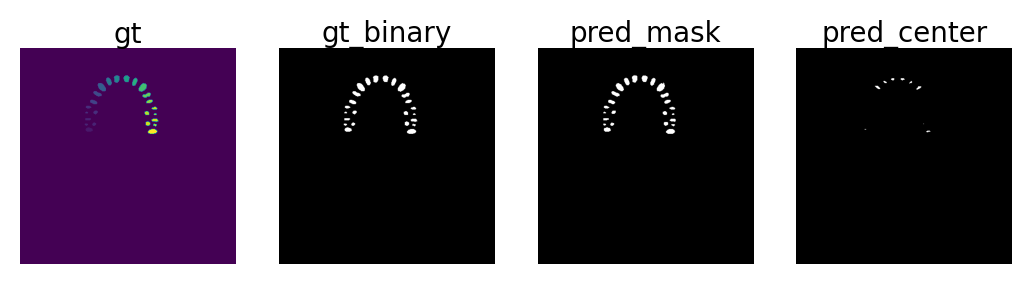

In [37]:
pid = '1001213121_20180115'


model_name = 'cswinunetr_96_3_mask'

exp_name = 'exp_1_drop0_0_01_mask' 

root_exp_dir = os.path.join(workspace_dir, 'exps')

data_name = 'tooth'
mask_model = 'cswinunetr_96_3_mask'
mask_exp = 'exp_1_drop0_0_01_mask'

center_model = 'cswinunetr_96_3_center_edge'
center_exp = 'exp_2_drop0_0_01_center'

cbct_path = f'/nfs/Workspace/dataset/teeth/data50/image/{pid}.nii.gz'.format(pid)
gt_path = f'/nfs/Workspace/dataset/teeth/data50/label/{pid}.nii.gz'.format(pid)
mask_path = f'{root_exp_dir}/{mask_model}/{data_name}/{mask_exp}/infers/{pid}_prob.nii.gz'.format(pid)
center_path = f'{root_exp_dir}/{center_model}/{data_name}/{center_exp}/infers/{pid}.nii.gz'.format(pid)

save_path = os.path.join(root_exp_dir, 'mwt')
if not os.path.isdir(save_path):
    os.mkdir(save_path)
    

cbct_nii = sitk.ReadImage(cbct_path)
cbct_img = sitk.GetArrayFromImage(cbct_nii)

gt_nii = sitk.ReadImage(gt_path)
gt = sitk.GetArrayFromImage(gt_nii).astype(int)
gt_binary = gt.copy()
gt_labels_num = len(np.unique(gt))
gt_binary[gt>0] = 1
print('gt_labels_num = ', gt_labels_num)

pred_mask = sitk.ReadImage(mask_path)
pred_mask = sitk.GetArrayFromImage(pred_mask)

pred_center = sitk.ReadImage(center_path)
pred_center = sitk.GetArrayFromImage(pred_center).astype(int)

sid = 130

plt.figure(dpi=200)
# plt.imshow(cbct_img[slice_id,:,:], cmap='gray')
# plt.axis('off')
# out_name = '{}/{}_cbct.jpg'.format(save_path, pid)
# plt.savefig(out_name)

plt.subplot(141)
plt.title('gt')
plt.axis('off')
plt.imshow(gt[sid,:,:])
plt.subplot(142)
plt.title('gt_binary')
plt.axis('off')
plt.imshow(gt_binary[sid,:,:], cmap='gray')
plt.subplot(143)
plt.title('pred_mask')
plt.axis('off')
plt.imshow(pred_mask[sid,:,:], cmap='gray')
plt.subplot(144)
plt.title('pred_center')
plt.axis('off')
plt.imshow(pred_center[sid,:,:], cmap='gray')

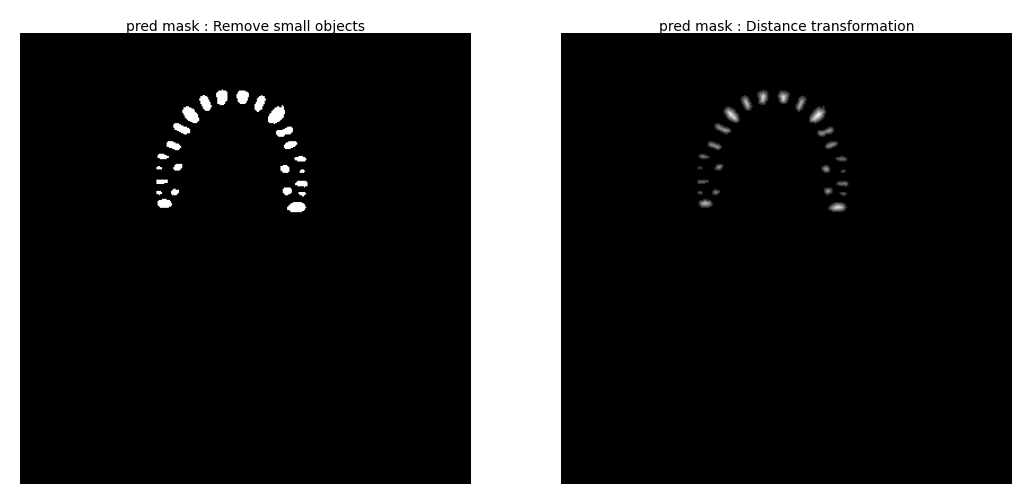

In [38]:
# pred mask : Remove small objects
pp_mask = pred_mask.copy()
pp_mask[pp_mask>=0.2] = 1
pp_mask[pp_mask<0.2] = 0
pp_mask = pp_mask.astype(bool)
pp_mask = morphology.remove_small_objects(pp_mask, min_size=500, connectivity=2)
pp_mask = pp_mask.astype(np.uint8)

# pred mask : Distance transformation
dist_pp_mask = distance_transform_edt(pp_mask)

plt.figure(dpi=200)
plt.rcParams['axes.titlesize'] = 5
plt.rcParams['axes.titlepad'] = 1
plt.subplot(121)
plt.title('pred mask : Remove small objects')
plt.axis('off')
plt.imshow(pp_mask[sid,:,:], cmap='gray')
plt.subplot(122)
plt.title('pred mask : Distance transformation')
plt.axis('off')
plt.imshow(dist_pp_mask[sid,:,:], cmap='gray')

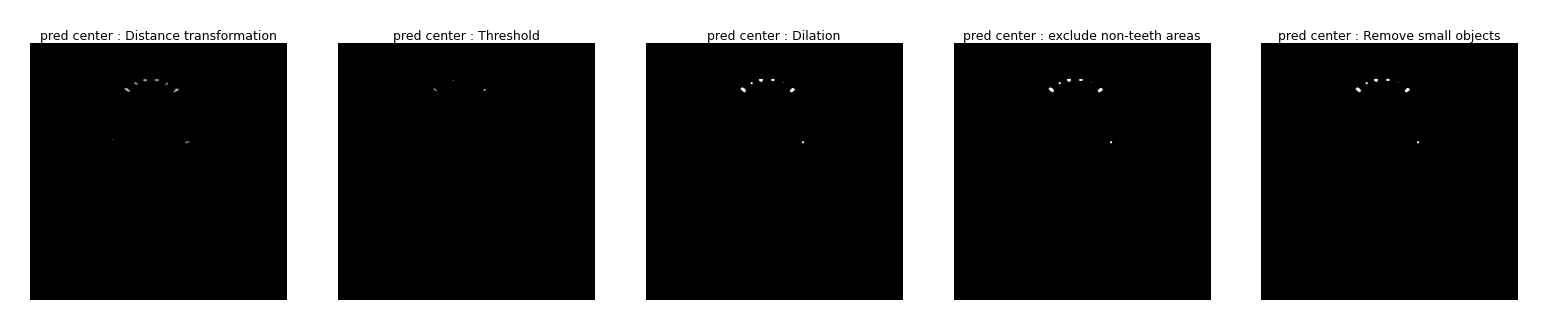

In [39]:
# pred center : Distance transformation
pp_center = pred_center.copy()
pp_center = pp_center.astype(bool)
dist_transform = distance_transform_edt(pp_center)
dis = np.unique(dist_transform)

# pred center : Threshold
ret, pp_center_th = cv.threshold(dist_transform, dis[2], 1, 0)
pp_center_th = pp_center_th.astype(np.uint8)

# pred center : Dilation 
pp_center = morphology.binary_dilation(pp_center_th, morphology.ball(2))
pp_center = pp_center.astype(np.uint8)

# pred center : exclude non-teeth areas
out_noise = cv.subtract(pp_center, pp_mask)
fg_temp = cv.subtract(pp_center, out_noise)

# pred center : Remove small objects
fg = fg_temp.astype(bool)
fg = morphology.remove_small_objects(fg, min_size=100, connectivity=2)
fg = morphology.remove_small_objects(fg, min_size=50, connectivity=1)
fg = fg.astype(np.uint8)

plt.figure(dpi=300)
plt.rcParams['axes.titlesize'] = 3
plt.rcParams['axes.titlepad'] = 1
plt.subplot(151)
plt.title('pred center : Distance transformation')
plt.axis('off')
plt.imshow(dist_transform[sid,:,:], cmap='gray')
plt.subplot(152)
plt.title('pred center : Threshold')
plt.axis('off')
plt.imshow(pp_center_th[sid,:,:], cmap='gray')
plt.subplot(153)
plt.title('pred center : Dilation')
plt.axis('off')
plt.imshow(pp_center[sid,:,:], cmap='gray')
plt.subplot(154)
plt.title('pred center : exclude non-teeth areas')
plt.axis('off')
plt.imshow(fg_temp[sid,:,:], cmap='gray')
plt.subplot(155)
plt.title('pred center : Remove small objects')
plt.axis('off')
plt.imshow(fg[sid,:,:], cmap='gray')

gt_num_markers:  32
our labels:  32


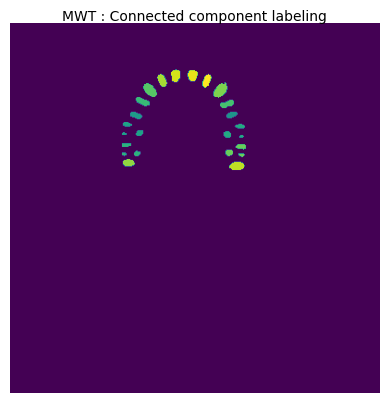

In [42]:
# MWT : Connected component labeling
markers, num_markers = label(fg)
label = watershed(-dist_pp_mask, markers, mask=pp_mask)

print('gt_num_markers: ', gt_labels_num)
print('our labels: ', len(np.unique(label)))

plt.rcParams['axes.titlesize'] = 10
plt.title('MWT : Connected component labeling')
plt.axis('off')
plt.imshow(label[sid,:,:])

In [43]:
# save labels
test_path = os.path.join('ToothDataset/cbcts')
out = sitk.GetImageFromArray(label)

out.SetOrigin(gt_nii.GetOrigin())
out.SetDirection(gt_nii.GetDirection())
out.SetSpacing(gt_nii.GetSpacing())

out_name = '{}/{}_label.nii.gz'.format(save_path, pid)

sitk.WriteImage(out, out_name)
print('save ', out_name)

save  /nfs/Workspace/TeethSeg/exps/mwt/1001213121_20180115_label.nii.gz
